# Credit Card Balance Dataset Analysis

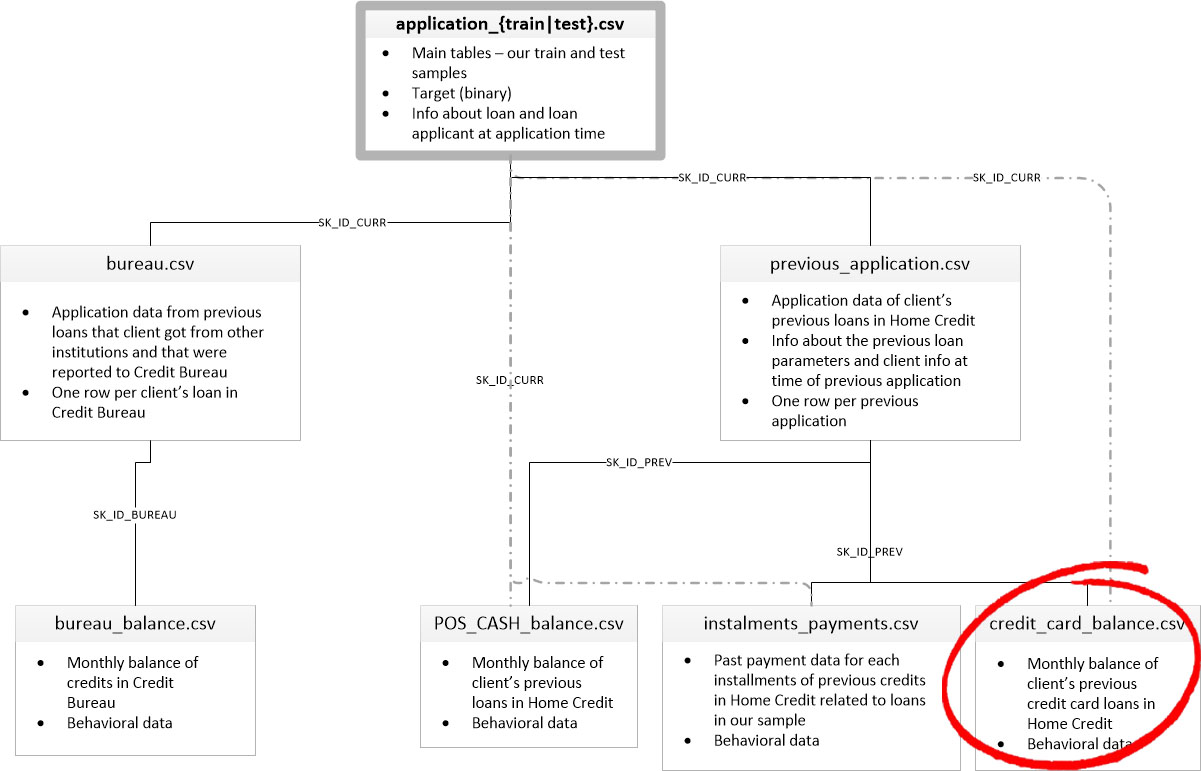

In this notebook I will try to explore credit_card_balance dataset and see what we can take from it.

Here is a short description from home credit about this dataset:
*  "Monthly balance snapshots of previous credit cards that the applicant has with Home Credit."

*  "This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows."

# Import Libraries

In [1]:
%load_ext nb_black
import homecredit_functions as hc
import imp

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", color_codes=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

RANDOM_STATE = 0

<IPython.core.display.Javascript object>

# Load Processed Application Datasets

### Application Test Processed Dataset

In [2]:
path_application_test_proc = "data/application_test_proc.csv"
df_application_test_proc = pd.read_csv(path_application_test_proc)

<IPython.core.display.Javascript object>

In [3]:
df_application_test_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,EXT_SOURCE_MIN,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,SK_ID_CURR
0,0.00000,0.00093,0.13079,0.25700,0.33754,0.04067,0.79045,0.88718,1.00000,1.00000,...,0.18150,0.13697,0.40086,0.11915,0.14272,0.03929,0.09607,0.99961,0.95603,100001
1,0.00000,0.00063,0.04439,0.49159,0.40389,0.03509,0.63043,0.77449,1.00000,1.00000,...,0.33184,0.43293,0.12210,0.25106,0.05407,0.02141,0.09867,0.99981,0.96073,100005
2,0.00000,0.00151,0.15437,0.26048,0.29262,0.03511,0.91184,0.51327,1.00000,1.00000,...,0.69517,0.62560,0.05975,0.03404,0.04381,0.03667,0.12049,0.99933,0.84987,100013
3,0.10526,0.00247,0.38202,0.36143,0.63433,0.04188,0.91894,0.41531,1.00000,1.00000,...,0.57990,0.10142,0.48475,0.05532,0.22152,0.05896,0.12821,0.99889,0.84877,100028
4,0.05263,0.00132,0.14494,0.13490,0.68709,0.04103,0.83787,0.40781,1.00000,1.00000,...,0.23000,0.24395,0.24761,0.23404,0.12441,0.04097,0.12821,0.99937,0.89487,100038


<IPython.core.display.Javascript object>

### Application Train Processed Dataset

In [4]:
path_application_train_proc = "data/application_train_proc.csv"
df_application_train_proc = pd.read_csv(path_application_train_proc)

<IPython.core.display.Javascript object>

In [5]:
df_application_train_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.31105,0.19041,0.54468,0.08367,0.02041,0.10717,0.99838,0.88820,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.07648,0.56183,0.08511,0.21774,0.04932,0.10870,0.99874,0.90937,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.23499,0.25688,0.05532,0.12821,0.02356,0.12821,0.99874,0.98744,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.55299,0.07905,0.06809,0.05132,0.02592,0.12049,0.99957,0.93432,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.18279,0.32191,0.15319,0.15483,0.04978,0.12821,0.99968,0.95478,0,100007


<IPython.core.display.Javascript object>

# EDA

## Credit Card Balance Dataset

In [6]:
path_credit_balance = "data/credit_card_balance.csv"
df_credit_balance = pd.read_csv(path_credit_balance)

<IPython.core.display.Javascript object>

In [7]:
df_credit_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97000,135000,0.00000,877.50000,0.00000,877.50000,1700.32500,...,0.00000,0.00000,0.00000,1,0.00000,1.00000,35.00000,Active,0,0
1,2582071,363914,-1,63975.55500,45000,2250.00000,2250.00000,0.00000,0.00000,2250.00000,...,64875.55500,64875.55500,1.00000,1,0.00000,0.00000,69.00000,Active,0,0
2,1740877,371185,-7,31815.22500,450000,0.00000,0.00000,0.00000,0.00000,2250.00000,...,31460.08500,31460.08500,0.00000,0,0.00000,0.00000,30.00000,Active,0,0
3,1389973,337855,-4,236572.11000,225000,2250.00000,2250.00000,0.00000,0.00000,11795.76000,...,233048.97000,233048.97000,1.00000,1,0.00000,0.00000,10.00000,Active,0,0
4,1891521,126868,-1,453919.45500,450000,0.00000,11547.00000,0.00000,11547.00000,22924.89000,...,453919.45500,453919.45500,0.00000,1,0.00000,1.00000,101.00000,Active,0,0


<IPython.core.display.Javascript object>

In [8]:
df_credit_balance.select_dtypes(["float64", "int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.00000,1904503.58990,536469.47056,1000018.00000,1434385.00000,1897122.00000,2369327.75000,2843496.00000
SK_ID_CURR,3840312.00000,278324.20729,102704.47513,100006.00000,189517.00000,278396.00000,367580.00000,456250.00000
MONTHS_BALANCE,3840312.00000,-34.52192,26.66775,-96.00000,-55.00000,-28.00000,-11.00000,-1.00000
AMT_BALANCE,3840312.00000,58300.15526,106307.03102,-420250.18500,0.00000,0.00000,89046.68625,1505902.18500
AMT_CREDIT_LIMIT_ACTUAL,3840312.00000,153807.95740,165145.69952,0.00000,45000.00000,112500.00000,180000.00000,1350000.00000
AMT_DRAWINGS_ATM_CURRENT,3090496.00000,5961.32482,28225.68858,-6827.31000,0.00000,0.00000,0.00000,2115000.00000
AMT_DRAWINGS_CURRENT,3840312.00000,7433.38818,33846.07733,-6211.62000,0.00000,0.00000,0.00000,2287098.31500
AMT_DRAWINGS_OTHER_CURRENT,3090496.00000,288.16958,8201.98934,0.00000,0.00000,0.00000,0.00000,1529847.00000
AMT_DRAWINGS_POS_CURRENT,3090496.00000,2968.80485,20796.88705,0.00000,0.00000,0.00000,0.00000,2239274.16000
AMT_INST_MIN_REGULARITY,3535076.00000,3540.20413,5600.15412,0.00000,0.00000,0.00000,6633.91125,202882.00500


<IPython.core.display.Javascript object>

In [9]:
df_credit_balance.select_dtypes(["object"]).describe().T

,count,unique,top,freq
NAME_CONTRACT_STATUS,3840312,7,Active,3698436


<IPython.core.display.Javascript object>

**Observation:**:
* Dataset has mostly numerical features with one categorical features included.
* SK_DPD and SK_DPD_DEF has extreme max values. 

In [9]:
# Merge credit card balance dataset with application train dataset
df_credit_balance_analysis = df_credit_balance.merge(
    df_application_train_proc[["SK_ID_CURR", "TARGET"]], how="left", on="SK_ID_CURR"
)
df_credit_balance_analysis.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TARGET
0,2562384,378907,-6,56.97000,135000,0.00000,877.50000,0.00000,877.50000,1700.32500,...,0.00000,0.00000,1,0.00000,1.00000,35.00000,Active,0,0,nan
1,2582071,363914,-1,63975.55500,45000,2250.00000,2250.00000,0.00000,0.00000,2250.00000,...,64875.55500,1.00000,1,0.00000,0.00000,69.00000,Active,0,0,1.00000
2,1740877,371185,-7,31815.22500,450000,0.00000,0.00000,0.00000,0.00000,2250.00000,...,31460.08500,0.00000,0,0.00000,0.00000,30.00000,Active,0,0,nan
3,1389973,337855,-4,236572.11000,225000,2250.00000,2250.00000,0.00000,0.00000,11795.76000,...,233048.97000,1.00000,1,0.00000,0.00000,10.00000,Active,0,0,0.00000
4,1891521,126868,-1,453919.45500,450000,0.00000,11547.00000,0.00000,11547.00000,22924.89000,...,453919.45500,0.00000,1,0.00000,1.00000,101.00000,Active,0,0,0.00000


<IPython.core.display.Javascript object>

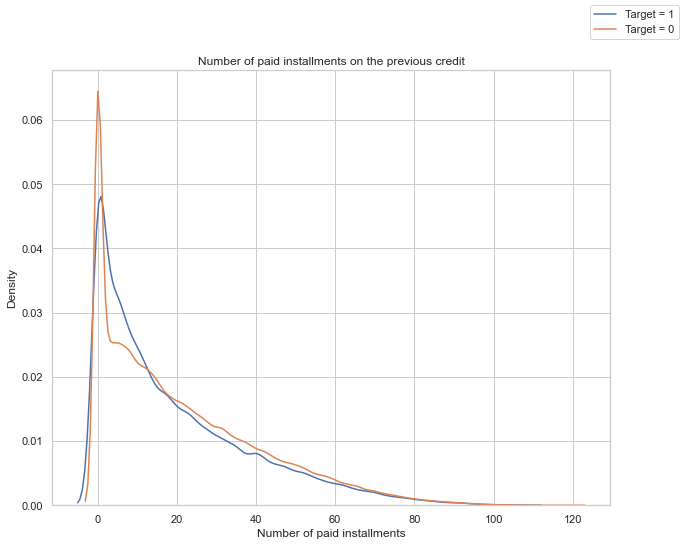

<IPython.core.display.Javascript object>

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.title("Number of paid installments on the previous credit")
plt.xlabel("Number of paid installments")
sns.kdeplot(
    df_credit_balance_analysis[df_credit_balance_analysis["TARGET"] == 1][
        "CNT_INSTALMENT_MATURE_CUM"
    ]
)
sns.kdeplot(
    df_credit_balance_analysis[df_credit_balance_analysis["TARGET"] == 0][
        "CNT_INSTALMENT_MATURE_CUM"
    ]
)

fig.legend(labels=["Target = 1", "Target = 0"])
plt.show()

**Observation:**:
* Both defaulters and people who paid their credit on time has pretty same number of paid installments on previous credit card distributions. Although people who paid their credit has seemingly more 0 number of installments.

# Data Wrangling

## Correlation

### Correlation with target

In [10]:
corrs_credit_balance = df_credit_balance_analysis.corr()[["TARGET"]].sort_values(
    by="TARGET", ascending=False
)
corrs_credit_balance = corrs_credit_balance.rename(columns={"TARGET": "target_corr"})
corrs_credit_balance = corrs_credit_balance.drop(["TARGET", "SK_ID_CURR"])
corrs_credit_balance

,target_corr
AMT_BALANCE,0.05010
AMT_TOTAL_RECEIVABLE,0.04984
AMT_RECIVABLE,0.04980
AMT_RECEIVABLE_PRINCIPAL,0.04969
AMT_INST_MIN_REGULARITY,0.03980
CNT_DRAWINGS_ATM_CURRENT,0.03844
CNT_DRAWINGS_CURRENT,0.03779
MONTHS_BALANCE,0.03569
CNT_DRAWINGS_POS_CURRENT,0.02954
AMT_DRAWINGS_ATM_CURRENT,0.02470


<IPython.core.display.Javascript object>

## Credit Card Balance Split Train/Test

In [11]:
%%time
df_credit_balance_agg  = hc.aggregate_samples(df_credit_balance.drop(columns=["SK_ID_PREV"]),"CRED_")

Wall time: 13.8 s


<IPython.core.display.Javascript object>

In [15]:
df_credit_balance_agg.head(5)

,SK_ID_CURR,CRED_MONTHS_BALANCE_MEAN,CRED_AMT_BALANCE_MEAN,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CRED_AMT_DRAWINGS_ATM_CURRENT_MEAN,CRED_AMT_DRAWINGS_CURRENT_MEAN,CRED_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CRED_AMT_DRAWINGS_POS_CURRENT_MEAN,CRED_AMT_INST_MIN_REGULARITY_MEAN,CRED_AMT_PAYMENT_CURRENT_MEAN,...,CRED_CNT_DRAWINGS_POS_CURRENT_SUM,CRED_CNT_INSTALMENT_MATURE_CUM_SUM,CRED_SK_DPD_SUM,CRED_SK_DPD_DEF_SUM,CRED_NAME_CONTRACT_STATUS_Approved_MEAN,CRED_NAME_CONTRACT_STATUS_Completed_MEAN,CRED_NAME_CONTRACT_STATUS_Demand_MEAN,CRED_NAME_CONTRACT_STATUS_Refused_MEAN,CRED_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_MEAN
0,100006,-3.50000,0.00000,270000.00000,nan,0.00000,nan,nan,0.00000,nan,...,0.00000,0.00000,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,100011,-38.50000,54482.11115,164189.18919,2432.43243,2432.43243,0.00000,0.00000,3956.22185,4843.06419,...,0.00000,1881.00000,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100013,-48.50000,18159.91922,131718.75000,6350.00000,5953.12500,0.00000,0.00000,1454.53955,7168.34625,...,0.00000,1666.00000,1,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100021,-10.00000,0.00000,675000.00000,nan,0.00000,nan,nan,0.00000,nan,...,0.00000,0.00000,0,0,0.00000,0.58824,0.00000,0.00000,0.00000,0.00000
4,100023,-7.50000,0.00000,135000.00000,nan,0.00000,nan,nan,0.00000,nan,...,0.00000,0.00000,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


<IPython.core.display.Javascript object>

In [13]:
%%time
# Splitting into train/test sets
df_train_sliced = df_application_train_proc[["SK_ID_CURR", "TARGET"]]
df_test_sliced = df_application_test_proc[["SK_ID_CURR"]]

df_credit_balance_train = df_train_sliced.merge(df_credit_balance_agg, how='left', on='SK_ID_CURR')
df_credit_balance_test = df_test_sliced.merge(df_credit_balance_agg, how='left', on='SK_ID_CURR')

Wall time: 3.07 s


<IPython.core.display.Javascript object>

## Missing values

In [14]:
hc.missing_values(df_credit_balance_train)

,Missing Values,% of Total Values
CRED_AMT_PAYMENT_CURRENT_MIN,246451,80.10000
CRED_AMT_PAYMENT_CURRENT_MEAN,246451,80.10000
CRED_AMT_PAYMENT_CURRENT_MAX,246451,80.10000
CRED_AMT_DRAWINGS_ATM_CURRENT_MIN,246371,80.10000
CRED_CNT_DRAWINGS_OTHER_CURRENT_MEAN,246371,80.10000
...,...,...
CRED_AMT_BALANCE_MEAN,220606,71.70000
CRED_AMT_DRAWINGS_CURRENT_MIN,220606,71.70000
CRED_AMT_INST_MIN_REGULARITY_MIN,220606,71.70000
CRED_AMT_PAYMENT_TOTAL_CURRENT_MIN,220606,71.70000


<IPython.core.display.Javascript object>

In [15]:
hc.missing_values(df_credit_balance_test)

,Missing Values,% of Total Values
CRED_AMT_DRAWINGS_ATM_CURRENT_MIN,37690,77.30000
CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN,37690,77.30000
CRED_CNT_DRAWINGS_OTHER_CURRENT_MIN,37690,77.30000
CRED_AMT_DRAWINGS_POS_CURRENT_MIN,37690,77.30000
CRED_AMT_DRAWINGS_OTHER_CURRENT_MIN,37690,77.30000
...,...,...
CRED_AMT_BALANCE_MEAN,32091,65.80000
CRED_AMT_DRAWINGS_CURRENT_MIN,32091,65.80000
CRED_AMT_INST_MIN_REGULARITY_MIN,32091,65.80000
CRED_AMT_PAYMENT_TOTAL_CURRENT_MIN,32091,65.80000


<IPython.core.display.Javascript object>

As we can see there are very high numbers of missing values, which reached more than 60 percentage of total values, most likely this dataset won't be very useful because of it. I will try to impute missing values with median values and check if this can produce any meaningful model metrics.

## Impute Missing Values

In [16]:
df_credit_balance_train_imp, df_credit_balance_test_imp = hc.impute_missing_num(
    df_credit_balance_train, df_credit_balance_test, df_credit_balance_test.columns
)

<IPython.core.display.Javascript object>

In [18]:
hc.missing_values(df_credit_balance_train_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

In [19]:
hc.missing_values(df_credit_balance_test_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

# Scale

In [20]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_credit_balance_train_imp,
    df_credit_balance_test_imp,
)

<IPython.core.display.Javascript object>

In [21]:
df_train_full_scaled.head(5)

,CRED_MONTHS_BALANCE_MEAN,CRED_AMT_BALANCE_MEAN,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CRED_AMT_DRAWINGS_ATM_CURRENT_MEAN,CRED_AMT_DRAWINGS_CURRENT_MEAN,CRED_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CRED_AMT_DRAWINGS_POS_CURRENT_MEAN,CRED_AMT_INST_MIN_REGULARITY_MEAN,CRED_AMT_PAYMENT_CURRENT_MEAN,CRED_AMT_PAYMENT_TOTAL_CURRENT_MEAN,...,CRED_SK_DPD_SUM,CRED_SK_DPD_DEF_SUM,CRED_NAME_CONTRACT_STATUS_Approved_MEAN,CRED_NAME_CONTRACT_STATUS_Completed_MEAN,CRED_NAME_CONTRACT_STATUS_Demand_MEAN,CRED_NAME_CONTRACT_STATUS_Refused_MEAN,CRED_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_MEAN,TARGET,SK_ID_CURR
0,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,100002.00000
1,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100003.00000
2,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100004.00000
3,0.94917,0.00315,0.20000,0.00504,0.00000,0.00000,0.00034,0.00000,0.00872,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100006.00000
4,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100007.00000


<IPython.core.display.Javascript object>

# Baseline model

In [22]:
X_train_full = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

y_train_full = df_train_full_scaled["TARGET"]

<IPython.core.display.Javascript object>

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

## LGBM

In [24]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [25]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 5.64 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [26]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.8747764300347957
Validation accuracy is 0.866315464286295
Training precision is 0.21724529861541642
Validation precision is 0.16164554332017453
Training recall is 0.21173212487411883
Validation recall is 0.1566968781470292
Training ROC AUC is 0.6216022421244659
Validation ROC AUC is 0.5623609046266311


<IPython.core.display.Javascript object>

In [27]:
df_scores = pd.DataFrame()

dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Baseline with all features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline with all features,0.87478,0.86632,0.21725,0.16165,0.21173,0.15670,0.62160,0.56236


<IPython.core.display.Javascript object>

Unfortunately this dataset gave us very small ROC_AUC validation score. One of the main reason is big amount of missing values.

In [28]:
hc.get_importance(LGBM_clsf, X_train_full, 20)

,Feature,Weight
2,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,129
62,CRED_AMT_CREDIT_LIMIT_ACTUAL_SUM,122
8,CRED_AMT_PAYMENT_CURRENT_MEAN,90
14,CRED_CNT_DRAWINGS_CURRENT_MEAN,88
24,CRED_AMT_DRAWINGS_CURRENT_MAX,82
13,CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN,80
68,CRED_AMT_PAYMENT_CURRENT_SUM,77
48,CRED_AMT_PAYMENT_CURRENT_MIN,77
34,CRED_CNT_DRAWINGS_CURRENT_MAX,70
28,CRED_AMT_PAYMENT_CURRENT_MAX,69


<IPython.core.display.Javascript object>

# Save Final Processed DataFrames

In [29]:
df_scores.to_csv("data/credit_card_balance_scores.csv", index=False)

<IPython.core.display.Javascript object>

In [27]:
df_train_full_scaled.drop(columns=["TARGET"]).to_csv(
    "data/credit_card_balance_train_proc.csv", index=False
)
df_test_full_scaled.to_csv("data/credit_card_balance_test_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [28]:
pd.read_csv("data/credit_card_balance_train_proc.csv")

,CRED_MONTHS_BALANCE_MEAN,CRED_AMT_BALANCE_MEAN,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CRED_AMT_DRAWINGS_ATM_CURRENT_MEAN,CRED_AMT_DRAWINGS_CURRENT_MEAN,CRED_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CRED_AMT_DRAWINGS_POS_CURRENT_MEAN,CRED_AMT_INST_MIN_REGULARITY_MEAN,CRED_AMT_PAYMENT_CURRENT_MEAN,CRED_AMT_PAYMENT_TOTAL_CURRENT_MEAN,...,CRED_CNT_INSTALMENT_MATURE_CUM_SUM,CRED_SK_DPD_SUM,CRED_SK_DPD_DEF_SUM,CRED_NAME_CONTRACT_STATUS_Approved_MEAN,CRED_NAME_CONTRACT_STATUS_Completed_MEAN,CRED_NAME_CONTRACT_STATUS_Demand_MEAN,CRED_NAME_CONTRACT_STATUS_Refused_MEAN,CRED_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_MEAN,SK_ID_CURR
0,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100002.00000
1,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100003.00000
2,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100004.00000
3,0.94917,0.00315,0.20000,0.00504,0.00000,0.00000,0.00034,0.00000,0.00872,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100006.00000
4,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100007.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456251.00000
307507,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456252.00000
307508,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456253.00000
307509,0.77633,0.03191,0.11091,0.00504,0.00309,0.00000,0.00034,0.03950,0.00872,0.00364,...,0.00628,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456254.00000


<IPython.core.display.Javascript object>